In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
import jax.numpy as np
from jax import grad, jit, vmap
from jax.experimental.ode import odeint
from functools import partial
from jax_cosmo import Planck15, background, Cosmology
import jax_cosmo.ops as ops
from jax_cosmo.utils import a2z, z2a
from jax_cosmo.power import linear_matter_power
import jax_cosmo.constants as const

Populating the interactive namespace from numpy and matplotlib


In [2]:
# First, let's define some analytic dndz
def smail_nz(z, a=2.0, b=1.5,z0=1.):
    return z**a * np.exp(-(z / z0)**b)

In [3]:
# Compute the normalization of the nz integral  
from scipy.integrate import simps
simps(smail_nz(linspace(0,5,100)), linspace(0,5,100))

/home/francois/.local/lib/python3.7/site-packages/jax/lib/xla_bridge.py:116: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


0.6665640513688308

In [4]:
def smail_nz(z, a=2.0, b=1.5,z0=1.):
    return z**a * np.exp(-(z / z0)**b)/0.6665640513688308

In [5]:
simps(smail_nz(linspace(0,5,100)), linspace(0,5,100))

1.000000009429739

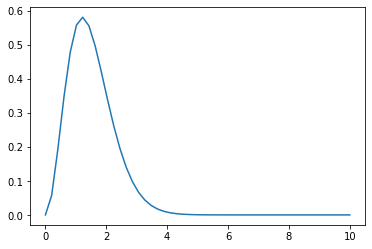

In [6]:
# Plotting the nz
z = np.linspace(0,10)
plot(z, smail_nz(z))

In [7]:
# get a cosmology
cosmo = Cosmology(Omega_c=0.3, Omega_b=0.05, h=0.7, 
                  sigma8 = 0.8, n_s=0.96, Omega_k=0.,
                  w0=-1., wa=0.)

In [8]:
def lensing_kernel(cosmo, chi, pz=smail_nz):
    """
    Compute lensing efficiency integrated over redshift distribution
    
    W(chi)
    
    This only works in flat.... but ok...
    """
    # Get intergration bounds
    z_min = a2z(background.a_of_chi(cosmo, chi))[0]
    
    def integrand(y, z, chi, cosmo):
        chi_prime = background.radial_comoving_distance(cosmo, z2a(z)) 
        return pz(z) * (chi_prime - chi)/(chi_prime + 1e-5)
    y = odeint(integrand, 0., np.linspace(z_min, 10.0, 10), chi, cosmo)
    return  y[-1]

In [9]:
# Batching this lensing kernel
w = vmap(lensing_kernel, (None, 0))

In [10]:
# Now we can compute the angular_cl using Limber
def angular_cl(cosmo, ell):
    
    atab = np.linspace(0.1,1.)
    r = background.radial_comoving_distance(cosmo, atab)
    
    # Tabulate the lensing kernel
    wtab = w(cosmo, r)
    
    def integrand(y, chi, cosmo, ell, atab, wtab):
        print("Bonjour")
        
        # Step 1: retrieve scale factor for given chi
        a = background.a_of_chi(cosmo, chi)

        # Step 2: get the powers pectrum for this combination of chi and a
        k = (ell+0.5)/chi
        pk = linear_matter_power(cosmo, k, a)
        
        # Step 3: Get the lensing kernel evaluated at given a
        kernel = ops.interp(np.atleast_1d(a), atab, wtab)[0]
        
        # Step 4: return the integrand
        return  (1. + a2z(a))**2 * pk * kernel**2 
    
    # Integrate from 10 to 7000 Mpc/h we probably should turn this into and integral over a
    y = odeint(integrand, 0., np.linspace(10., 7000.,100), cosmo, ell, atab, wtab)
    
    # Lensing prefactors in Limber
    factor = (3.0 * const.H0**2 * cosmo.Omega_m / (2.0 * const.c**2))**2 
    factor *= ((ell-1)*(ell)*(ell+1)*(ell+2))/(ell+0.5)**4

    return factor * y[-1]

In [11]:
# Batch it to compute a bunch of ells at the same time 
batched_angular_cl = jit(vmap(angular_cl, (None, 0)))

In [12]:
batched_angular_cl(cosmo, np.linspace(50,100,100));

/home/francois/.local/lib/python3.7/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/francois/.local/lib/python3.7/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/francois/.local/lib/python3.7/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype <class 'jax.num

Bonjour
Bonjour
Bonjour


DeviceArray([2.44489566e-08, 2.42529392e-08, 2.40594229e-08,
             2.38680506e-08, 2.36789219e-08, 2.34917241e-08,
             2.33069226e-08, 2.31239952e-08, 2.29434889e-08,
             2.27646773e-08, 2.25882637e-08, 2.24138184e-08,
             2.22413714e-08, 2.20707559e-08, 2.19018759e-08,
             2.17351008e-08, 2.15703935e-08, 2.14072298e-08,
             2.12460769e-08, 2.10864961e-08, 2.09290469e-08,
             2.07733741e-08, 2.06188773e-08, 2.04667856e-08,
             2.03161949e-08, 2.01672083e-08, 2.00197814e-08,
             1.98739052e-08, 1.97301286e-08, 1.95871923e-08,
             1.94464622e-08, 1.93069454e-08, 1.91689704e-08,
             1.90324769e-08, 1.88975040e-08, 1.87636768e-08,
             1.86319689e-08, 1.85014208e-08, 1.83720044e-08,
             1.82437407e-08, 1.81176905e-08, 1.79914981e-08,
             1.78682882e-08, 1.77456663e-08, 1.76242168e-08,
             1.75041937e-08, 1.73851600e-08, 1.72675865e-08,
             1.71511747e

/home/francois/.local/lib/python3.7/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/francois/.local/lib/python3.7/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


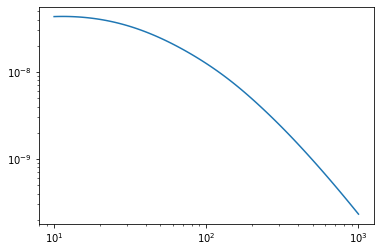

In [14]:
loglog(np.logspace(1,3,100), batched_angular_cl(cosmo, np.logspace(1,3,100)))

In [16]:
jax_cl = batched_angular_cl(cosmo, np.logspace(1,3,100));

/home/francois/.local/lib/python3.7/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/francois/.local/lib/python3.7/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [18]:
# Now we compare to CCL
ccl_cls = load('/home/francois/Downloads/ccl_cls.npy')

Text(0, 0.5, 'Lensing angular $C_\\ell$')

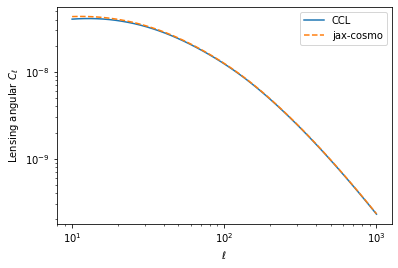

In [19]:
loglog(np.logspace(1,3), ccl_cls, label='CCL')
loglog(np.logspace(1,3,100), jax_cl, '--', label='jax-cosmo')
legend()
xlabel(r'$\ell$')
ylabel('Lensing angular $C_\ell$')